In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

In [ ]:
df = pd.read_csv('/content/merged_dataset.csv')
print(df.head())

   duration proto    src     dst  spkts  dpkts   attack
0       0.0   tcp  491.0     0.0      2     25   normal
1       0.0   udp  146.0     0.0      1      1   normal
2       0.0   tcp    0.0     0.0      6     26  neptune
3       0.0   tcp  232.0  8153.0      5    255   normal
4       0.0   tcp  199.0   420.0     32    255   normal


/tmp/ipython-input-2198946454.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/merged_dataset.csv')


In [ ]:
proto_to_num = {
    'icmp': 1,
    'tcp': 6,
    'udp': 17,
}

def encode_proto(val):
    try:
        return int(val)
    except:
        val_str = str(val).lower()
        return proto_to_num.get(val_str, -1)

df['proto'] = df['proto'].apply(encode_proto)

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import shuffle

df = shuffle(df, random_state=42).reset_index(drop=True)

df['attack_name'] = df['attack'].astype(str).str.lower()

attack_mapping = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'apache2': 'DoS',
    'udpstorm': 'DoS', 'processtable': 'DoS', 'mailbomb': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L',
    'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'rootkit': 'U2R', 'perl': 'U2R',
}
df['attack_category'] = df['attack_name'].map(attack_mapping).fillna('Other')
print(" Attack category distribution:\n", df['attack_category'].value_counts())

le_attack_grouped = LabelEncoder()
df['attack_grouped'] = le_attack_grouped.fit_transform(df['attack_category'])

feature_columns = df.drop(columns=['attack', 'attack_name', 'attack_category', 'attack_grouped']).columns
X = df[feature_columns]
y = df['attack_grouped']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

 Attack category distribution:
 attack_category
Other     807776
Normal    170054
DoS        53385
Probe      14077
R2L         3194
U2R           89
Name: count, dtype: int64


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 838860, number of used features: 6
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791760
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 LightGBM Accuracy: 96.05%
 LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     10677
           1       0.83      0.98      0.90     34011
           2       1.00      0.96      0.98    161555
           3       0.81      0.96      0.88      2815
           4       0.84      0.97      0.90       639
           5       0.23      0.78      0.35        18

    accuracy                           0.96    209715
   macro avg       0.78      0.93      0.83    209715
weighted avg       0.97      0.96      0.96    209715



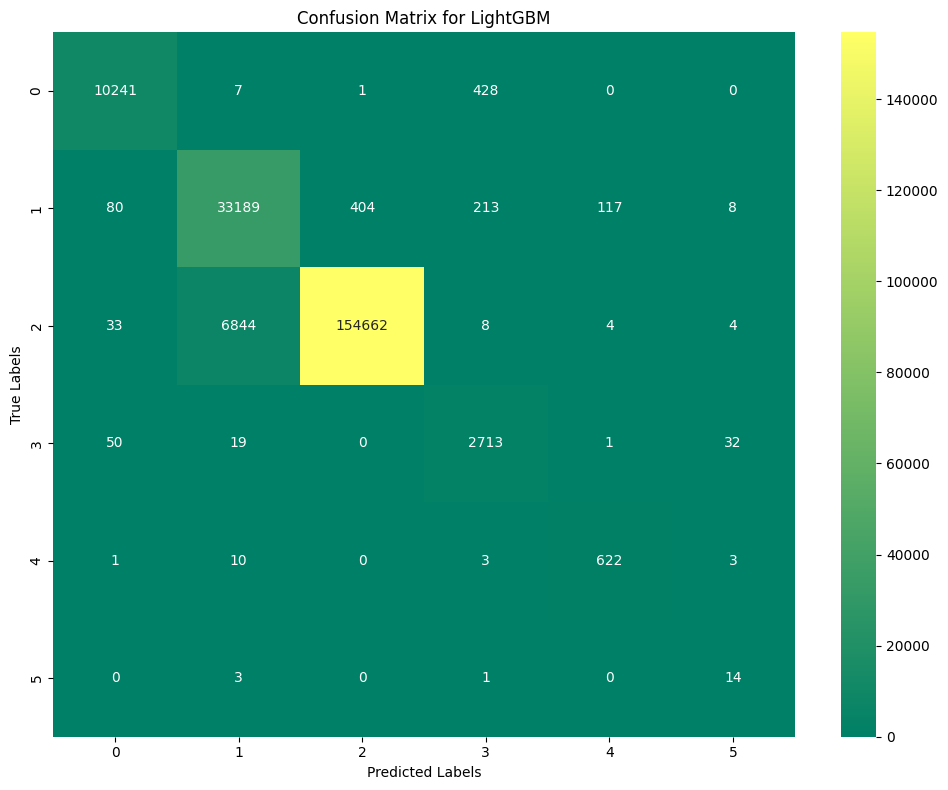

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lgb_model = lgb.LGBMClassifier(
    n_estimators=150,
    max_depth=15,
    min_child_samples=4,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred_lgb)
report_lgb = classification_report(y_test, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

print(f" LightGBM Accuracy: {acc_lgb * 100:.2f}%")
print(" LightGBM Classification Report:\n", report_lgb)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lgb, annot=True, fmt='d', cmap='summer', cbar=True)

plt.title('Confusion Matrix for LightGBM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

y_prob_lgb = lgb_model.predict_proba(X_test)

try:
    roc_auc_lgb = roc_auc_score(
        y_test,
        y_prob_lgb,
        multi_class='ovr',
        average='weighted'
    )
    print(f" Weighted ROC-AUC Score: {roc_auc_lgb:.4f}")
except ValueError:
    print(" ROC-AUC calculation failed for LightGBM (possibly due to only one class in y_test)")

mcc_lgb = matthews_corrcoef(y_test, y_pred_lgb)
print(f" Matthews Correlation Coefficient: {mcc_lgb:.4f}")

kappa_lgb = cohen_kappa_score(y_test, y_pred_lgb)
print(f" Cohen’s Kappa Score: {kappa_lgb:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Weighted ROC-AUC Score: 0.9975
 Matthews Correlation Coefficient: 0.9035
 Cohen’s Kappa Score: 0.9005


In [ ]:
import time

y_test_array = y_test.values

start = time.time()
preds_lgb = lgb_model.predict(X_test)
end = time.time()

total_time_ms = (end - start) * 1000
avg_time_ms = total_time_ms / len(X_test)

correct_flags_lgb = (preds_lgb == y_test_array).astype(int)
inference_times_lgb = [avg_time_ms] * len(X_test)

df_lgb = pd.DataFrame({
    'inference_time_ms': inference_times_lgb,
    'is_correct': correct_flags_lgb
})

df_lgb.to_csv("LightGBM.csv", index=False)
print(" Saved: LightGBM.csv")
print(f" Avg Inference Time: {avg_time_ms:.4f} ms per sample")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Saved: LightGBM.csv
 Avg Inference Time: 0.0492 ms per sample


 Random Forest Accuracy: 95.96%
 Randon Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     10677
           1       0.82      0.98      0.89     34011
           2       1.00      0.95      0.98    161555
           3       0.84      0.97      0.90      2815
           4       0.87      0.97      0.92       639
           5       0.50      0.78      0.61        18

    accuracy                           0.96    209715
   macro avg       0.84      0.94      0.88    209715
weighted avg       0.97      0.96      0.96    209715



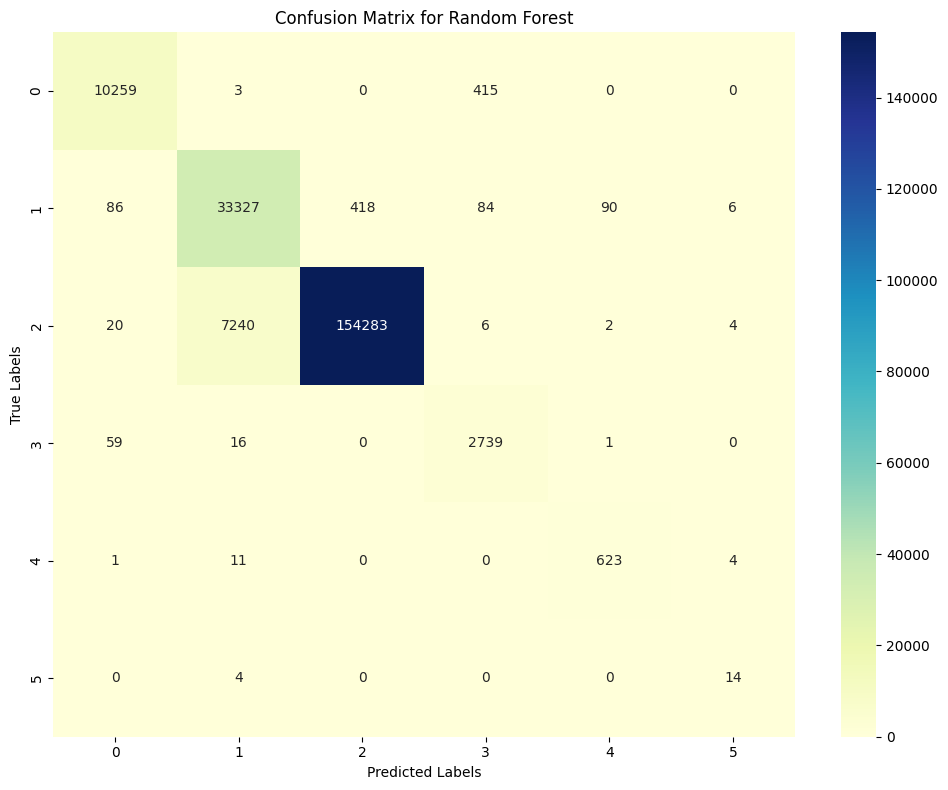

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f" Random Forest Accuracy: {acc * 100:.2f}%")
print(" Randon Forest Classification Report:\n", report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True)

plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
y_prob = rf_model.predict_proba(X_test)
try:
    roc_auc = roc_auc_score(
        y_test,
        y_prob,
        multi_class='ovr',
        average='weighted'
    )
    print(f" Weighted ROC-AUC Score: {roc_auc:.4f}")
except ValueError:
    print(" ROC-AUC calculation failed (possibly due to 1 class in y_test)")

mcc = matthews_corrcoef(y_test, y_pred)
print(f" Matthews Correlation Coefficient (MCC): {mcc:.4f}")

kappa = cohen_kappa_score(y_test, y_pred)
print(f" Cohen’s Kappa Score: {kappa:.4f}")

 Weighted ROC-AUC Score: 0.9978
 Matthews Correlation Coefficient (MCC): 0.9018
 Cohen’s Kappa Score: 0.8984


In [ ]:
import time

y_test_array = y_test.values

start = time.time()
preds = rf_model.predict(X_test)  # batch prediction
end = time.time()

total_time_ms = (end - start) * 1000
avg_time_ms = total_time_ms / len(X_test)

correct_flags = (preds == y_test_array).astype(int)

inference_times = [avg_time_ms] * len(X_test)

df_rf = pd.DataFrame({
    'inference_time_ms': inference_times,
    'is_correct': correct_flags
})

df_rf.to_csv("Random Forest.csv", index=False)
print(" Saved: Random Forest.csv")
print(f" Avg Inference Time: {avg_time_ms:.4f} ms per sample")

 Saved: Random Forest.csv
 Avg Inference Time: 0.0105 ms per sample


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:07:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost Accuracy: 97.40%
 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     10677
           1       0.95      0.90      0.92     34011
           2       0.98      0.99      0.99    161555
           3       0.85      0.96      0.90      2815
           4       0.94      0.95      0.94       639
           5       0.60      0.50      0.55        18

    accuracy                           0.97    209715
   macro avg       0.89      0.88      0.88    209715
weighted avg       0.97      0.97      0.97    209715



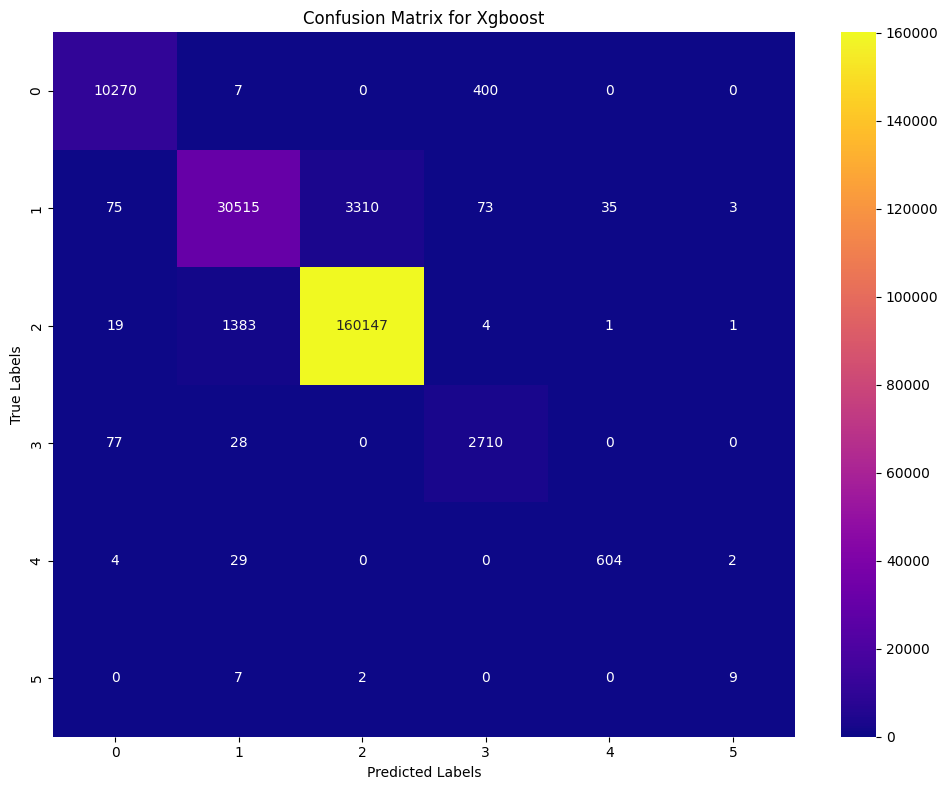

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=150,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f" XGBoost Accuracy: {acc * 100:.2f}%")
print(" XGBoost Classification Report:\n", report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='plasma', cbar=True)

plt.title('Confusion Matrix for Xgboost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

try:
    y_proba = xgb_model.predict_proba(X_test)

    roc_auc = roc_auc_score(
        y_test,
        y_proba,
        multi_class='ovr',
        average='weighted'
    )
    print(f" Weighted ROC-AUC Score: {roc_auc:.4f}")
except Exception as e:
    print(f" ROC-AUC could not be calculated: {e}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f" Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Cohen’s Kappa Score
kappa = cohen_kappa_score(y_test, y_pred)
print(f" Cohen’s Kappa Score: {kappa:.4f}")

 Weighted ROC-AUC Score: 0.9977
 Matthews Correlation Coefficient (MCC): 0.9304
 Cohen’s Kappa Score: 0.9300


In [ ]:
import time

y_test_array = y_test.values

start = time.time()
preds = xgb_model.predict(X_test)
end = time.time()

total_time_ms = (end - start) * 1000
avg_time_ms = total_time_ms / len(X_test)

correct_flags = (preds == y_test_array).astype(int)

inference_times = [avg_time_ms] * len(X_test)

df_xgb = pd.DataFrame({
    'inference_time_ms': inference_times,
    'is_correct': correct_flags
})


df_xgb.to_csv("XGBoost.csv", index=False)
print(" Saved: XGBoost.csv")
print(f" Avg Inference Time: {avg_time_ms:.4f} ms per sample")

 Saved: XGBoost.csv
 Avg Inference Time: 0.0244 ms per sample


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Ensemble Accuracy: 96.55%
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97     10677
           1       0.85      0.97      0.91     34011
           2       0.99      0.96      0.98    161555
           3       0.85      0.97      0.91      2815
           4       0.90      0.97      0.94       639
           5       0.58      0.78      0.67        18

    accuracy                           0.97    209715
   macro avg       0.86      0.94      0.89    209715
weighted avg       0.97      0.97      0.97    209715



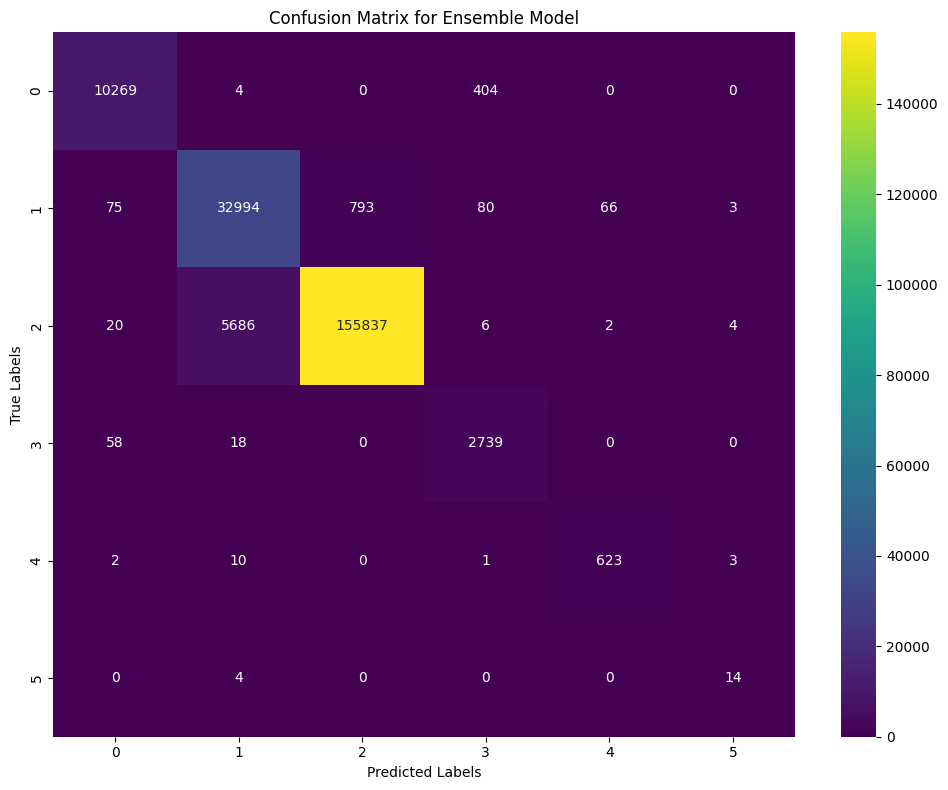

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_model = LGBMClassifier(
    n_estimators=150,
    max_depth=15,
    min_child_samples=4,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
report_ensemble = classification_report(y_test, y_pred_ensemble)
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)

print(f"Ensemble Accuracy: {acc_ensemble * 100:.2f}%")
print("Ensemble Classification Report:\n", report_ensemble)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.title('Confusion Matrix for Ensemble Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

try:
    y_prob_ensemble = ensemble_model.predict_proba(X_test)

    if isinstance(y_prob_ensemble, list):
        import numpy as np
        y_prob_ensemble = np.mean(y_prob_ensemble, axis=0)

    roc_auc = roc_auc_score(
        y_test,
        y_prob_ensemble,
        multi_class='ovr',
        average='weighted'
    )
    print(f"Weighted ROC-AUC Score (Ensemble): {roc_auc:.4f}")

except Exception as e:
    print(f"ROC-AUC could not be calculated: {e}")

mcc = matthews_corrcoef(y_test, y_pred_ensemble)
print(f"Matthews Correlation Coefficient (Ensemble): {mcc:.4f}")

kappa = cohen_kappa_score(y_test, y_pred_ensemble)
print(f"Cohen’s Kappa Score (Ensemble): {kappa:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Weighted ROC-AUC Score (Ensemble): 0.9979
Matthews Correlation Coefficient (Ensemble): 0.9137
Cohen’s Kappa Score (Ensemble): 0.9119


In [ ]:
import time

y_test_array = y_test.values

start = time.time()
pred_all = ensemble_model.predict(X_test)
end = time.time()

total_time_ms = (end - start) * 1000
avg_time_ms = total_time_ms / len(X_test)

correct_flags = (pred_all == y_test_array).astype(int)

df_ensemble = pd.DataFrame({
    'inference_time_ms': [avg_time_ms] * len(X_test),
    'is_correct': correct_flags
})

df_ensemble.to_csv("Ensemble.csv", index=False)

print("Saved: Ensemble.csv")
print(f"Avg Inference Time per Sample: {avg_time_ms:.4f} ms")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Saved: Ensemble.csv
Avg Inference Time per Sample: 0.0606 ms
